# Estudo Comparativo de Modelos de Séries Temporais Nebulosas

[<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)


### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
### Disciplina de Sistemas Nebulosos

Professor: André Paim Lemos

Autores: Leonardo Ferreira (leauferreira@gmail.com) e Petrônio Silva (petronio.candido@gmail.com)

* [Revisão De Literatura](https://www.overleaf.com/read/rqqctmpzgsnt)
* [Apresentação](https://www.overleaf.com/read/tdwskgrscknv)


## Índice

1. [Importações Comuns](#Importações-Comuns)
2. [Dados de Treinamento e Validação](#Dados-de-Treinamento-e-Validação)
3. [Códigos Comuns](#Códigos-Comuns)
   1. [Funções de Pertinência](#Funções-de-Pertinência)
   2. [Conjuntos Nebulosos](#Conjuntos-Nebulosos)
   3. [Particionadores do Universo de Discurso](#Particionadores-do-Universo-de-Discurso)
3. [First Order Fuzzy Time Series](#First-Order-Fuzzy-Time-Series)
   1. [Fuzzy Logical Relationship Groups - FLRG](#Fuzzy-Logical-Relationship-Groups---FLRG)
   2. [Classe Princial - FTS](#Classe-Princial---FTS)
   3. [Testes](#Testes)
4. [Weighted Fuzzy Time Series](#Weighted-Fuzzy-Time-Series)
5. [Improved Weighted Fuzzy Time Series](#Improved-Weighted-Fuzzy-Time-Series)
5. [Exponentially Weighted Fuzzy Time Series](#Exponentially-Weighted-Fuzzy-Time-Series)
6. [High Order Fuzzy Time Series](#High-Order-Fuzzy-Time-Series)
7. [Comparação entre os modelos]()
8. [Referências](#References)

# Importações Comuns

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dados de Treinamento e Validação

### University Of Alabama Enrollments

O dataset abaixo foi retirado do artigo \cite{song1993fuzzy}

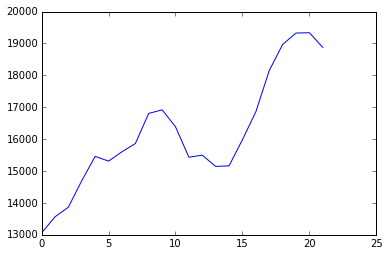

In [4]:
enrollments = pd.read_csv("DataSets/Enrollments.csv", sep=";")

plot(enrollments["Enrollments"])

### TAIEX - Taiwan Stock Exchange Index

O dataset foi provido por \cite{taiex}

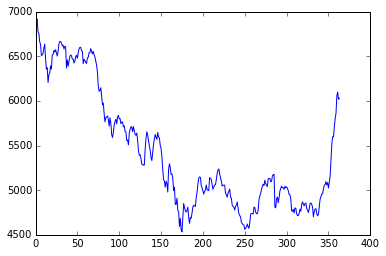

In [12]:
taiex = pd.read_csv("DataSets/TAIEX.csv", sep=",")
taiexsample = taiex["avg"][1:365]
plot(taiexsample)

# Códigos Comuns

### Funções de Pertinência

In [14]:
def trimf(x,parameters):
	if(x < parameters[0]):
		return 0
	elif(x >= parameters[0] and x < parameters[1]):
		return (x-parameters[0])/(parameters[1]-parameters[0])
	elif(x >= parameters[1] and x <= parameters[2]):
		return (parameters[2]-x)/(parameters[2]-parameters[1])
	else: 
		return 0

def trapmf(x, parameters):
		if(x < parameters[0]):
			return 0
		elif(x >= parameters[0] and x < parameters[1]):
			return (x-parameters[0])/(parameters[1]-parameters[0])
		elif(x >= parameters[1] and x <= parameters[2]):
			return 1
		elif(x >= parameters[2] and x <= parameters[3]):
			return (parameters[3]-x)/(parameters[3]-parameters[2])
		else: 
			return 0

def gaussmf(x,parameters):
		return math.exp(-0.5*((x-parameters[0]) / parameters[1] )**2)


def bellmf(x,parameters):
		return 1 / (1 + abs((xx - parameters[2])/parameters[0])**(2*parameters[1]))


def sigmf(x,parameters):
		return 1 / (1 + math.exp(-parameters[0] * (x - parameters[1])))


### Conjuntos Nebulosos

In [15]:
class FuzzySet:

	def __init__(self,name,mf,parameters,centroid):
		self.name = name
		self.mf = mf
		self.parameters = parameters
		self.centroid = centroid
        
	def membership(self,x):
		return self.mf(x,self.parameters)
    
	def __str__(self):
		return self.name + ": " + str(self.mf) + "(" + str(self.parameters) + ")"
    
    

### Particionadores do Universo de Discurso

In [16]:
def GridPartitionerTrimf(data,npart,names = None,prefix = "A"):
	sets = []
	dmax = max(data)
	dmin = min(data)
	dlen = dmax - dmin
	partlen = dlen / npart
	partition = dmin
	for c in range(npart):
		sets.append( FuzzySet(prefix+str(c),trimf,[partition-partlen, partition, partition+partlen], partition ) )
		partition = partition + partlen
		
	return sets

In [17]:
sts = GridPartitionerTrimf(enrollments["Enrollments"],10)
for s in sts:
    print(s)

A0: <function trimf at 0xaafcb7c4>([12426.799999999999, 13055, 13683.200000000001])
A1: <function trimf at 0xaafcb7c4>([13055.0, 13683.200000000001, 14311.400000000001])
A2: <function trimf at 0xaafcb7c4>([13683.200000000001, 14311.400000000001, 14939.600000000002])
A3: <function trimf at 0xaafcb7c4>([14311.400000000001, 14939.600000000002, 15567.800000000003])
A4: <function trimf at 0xaafcb7c4>([14939.600000000002, 15567.800000000003, 16196.000000000004])
A5: <function trimf at 0xaafcb7c4>([15567.800000000003, 16196.000000000004, 16824.200000000004])
A6: <function trimf at 0xaafcb7c4>([16196.000000000004, 16824.200000000004, 17452.400000000005])
A7: <function trimf at 0xaafcb7c4>([16824.200000000004, 17452.400000000005, 18080.600000000006])
A8: <function trimf at 0xaafcb7c4>([17452.400000000005, 18080.600000000006, 18708.800000000007])
A9: <function trimf at 0xaafcb7c4>([18080.600000000006, 18708.800000000007, 19337.000000000007])


### Funções Auxiliares

In [18]:
def rmse(a,b):
    return math.sqrt(sum(a-b)**2)/len(a)
    

# First Order Fuzzy Time Series

Os trabalhos pioneiros em séries temporais nebulosas são de \cite{song1993fuzzy} e a evolução apresentada por \cite{chen1996forecasting}. Nesses trabalhos define-se que o modelo de primeira ordem (\textit{First Order Fuzzy Time Series}) caracteriza-se por presumir que $F(t)$ é determinado unicamente por $F(t-1)$ ( ou $F(t-2)$ ou ... ou $F(t-m)$ ).

## Fuzzy Logical Relationship Groups - FLRG

In [19]:
class FLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = set()
	
	def append(self,c):
		self.consequent.add(c)

	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c
		return tmp + tmp2


In [20]:
flrgx = FLRG("A")
flrgx.append("B")
flrgx.append("C")
print(flrgx)

A -> B,C


## Classe Principal - FTS

In [33]:
class FTS:
	def __init__(self,order):
		self.sets = {}
		self.flrgs = {}
		self.order = order
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best
		
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		count = 0.0
		denom = 0.0

		for s in flrg.consequent:
			denom = denom + self.sets[s].centroid
			count = count + 1.0

		return denom/count
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = FLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual
	def predict(self,data):
		return self.defuzzy(data)
	def __str__(self):
		s = ""
		for c in self.flrgs:
			s = s + str(self.flrgs[c]) + "\n"
		return s  
	
	def plot(self,original):
		fig = plt.figure(figsize=[20,6])
		predicted = [self.predict(xx) for xx in original]
		error = rmse(original,predicted)
		plot(original)
		plot(predicted)
		ret = []
		ret.append(predicted)
		ret.append(error)
		return ret

## Testes

In [43]:
def SelecaoSimples_MenorRMSE(original,parameters,modelo):
	errors = []
	fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
	fig.suptitle("Comparação de modelos ")
	fig.set_size_inches(18, 10)
	ax0 = axs[0]
	ax0.set_title('Série Temporal')
	ax0.set_ylabel('F(T)')
	ax0.set_xlabel('T')
	ax0.plot(original,label="Original")
	min_rmse = 1000.0
	best = FTS(1)
	for p in parameters:
		sets = GridPartitionerTrimf(original,p)
		fts = modelo(1)
		fts.learn(original,sets)
		predicted = [fts.predict(xx) for xx in original]
		ax0.plot(predicted,label=str(p))
		error = rmse(original,predicted)
		errors.append(error)
		if error < min_rmse:
			min_rmse = error
			best = fts
	handles0, labels0 = ax0.get_legend_handles_labels()
	ax0.legend(handles0, labels0)
	ax1 = axs[1]
	ax1.set_title('Comparação dos Erros Quadráticos Médios')
	ax1.set_ylabel('RMSE')
	ax1.set_xlabel('Quantidade de Partições')
	ax1.set_xlim([min(parameters),max(parameters)])
	ax1.plot(parameters,errors)
	return best

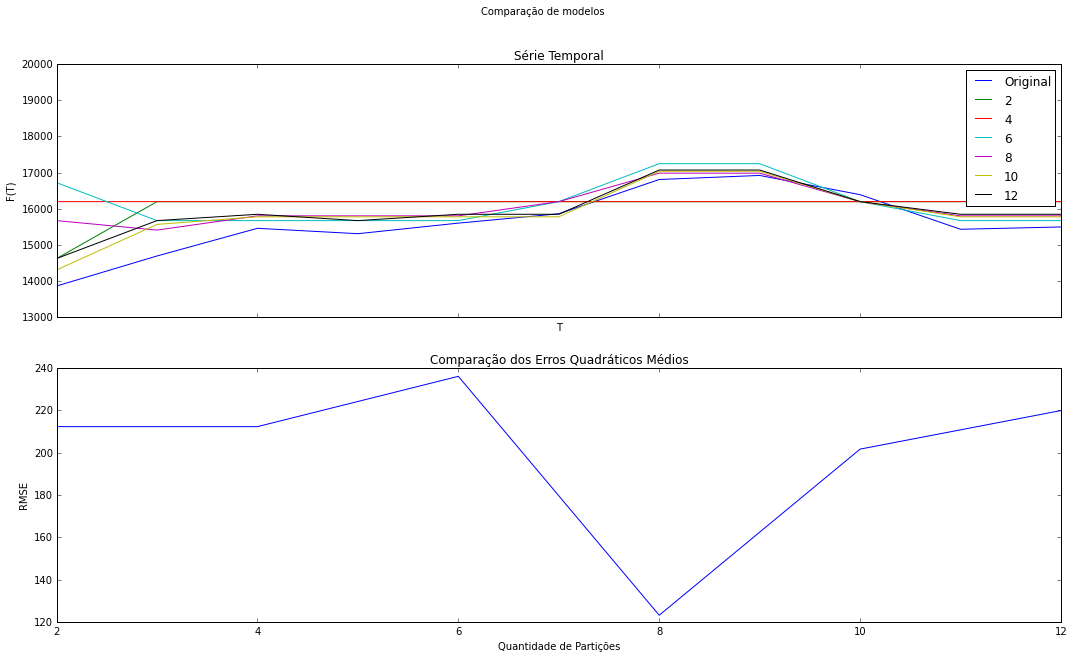

In [46]:
best = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[2,4,6,8,10,12],FTS)

In [36]:
print(best)

A5 -> A5,A4,A6
A4 -> A5,A3
A6 -> A7
A7 -> A7,A1
A2 -> A3
A0 -> A1
A3 -> A3,A4
A1 -> A2,A7,A1



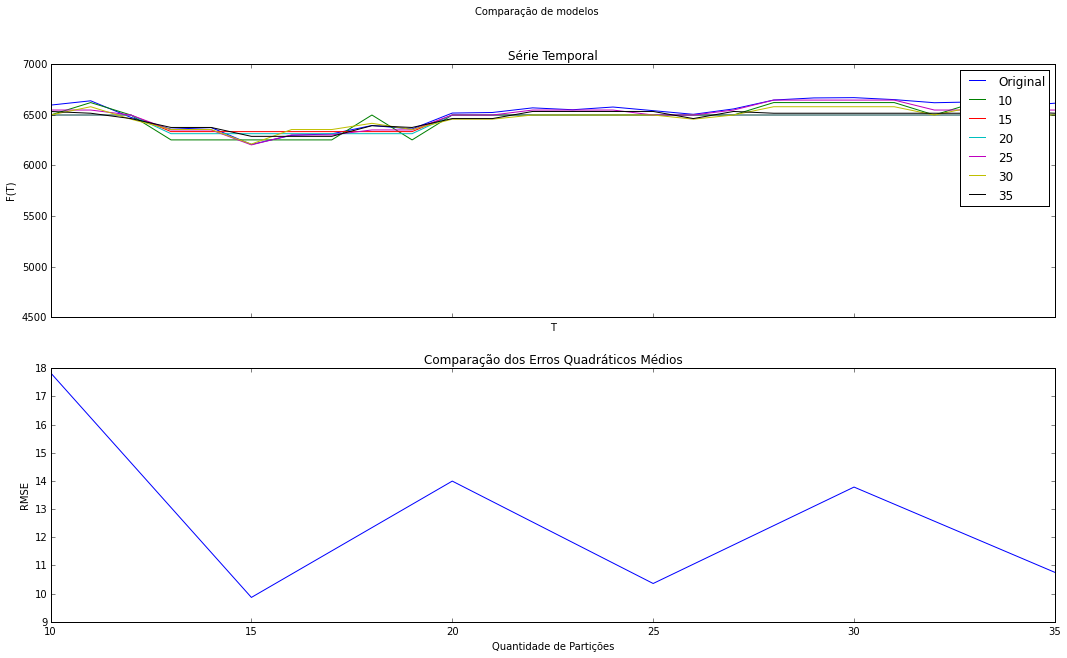

In [37]:
best2= SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,35])

In [38]:
print(best2)

A12 -> A12,A13,A11
A11 -> A12,A11,A10
A2 -> A2,A3,A1
A7 -> A7,A8,A6
A8 -> A7,A8,A9
A4 -> A5,A2,A4,A3
A1 -> A2,A0,A1
A5 -> A5,A4,A6
A13 -> A12,A13,A11
A14 -> A13,A14
A6 -> A5,A7,A6
A0 -> A0,A1
A9 -> A9,A8,A10
A3 -> A2,A3,A4
A10 -> A9,A14,A11,A10



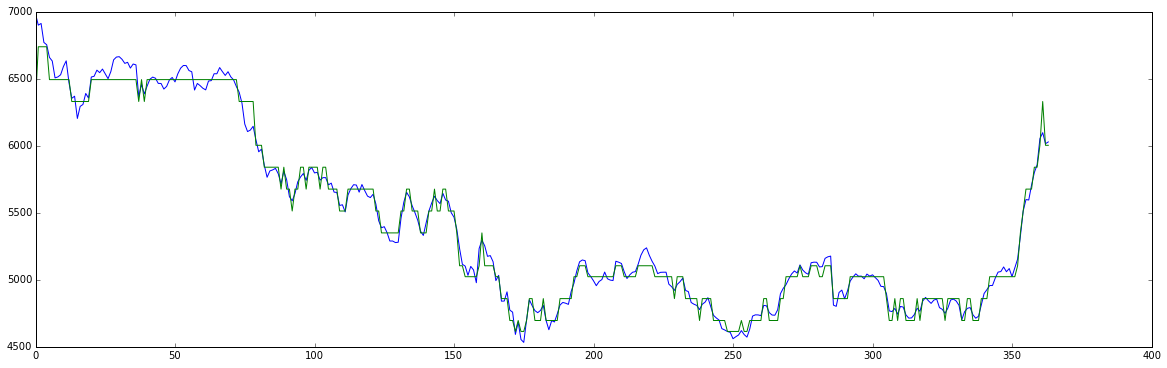

In [39]:
pred2 = best2.plot(taiexsample)

# Weighted Fuzzy Time Series

O trabalho de \cite{yu2005weighted} propõe um modelo  - as \textit{Weighted Fuzzy Time Series} -  em que os grupos de regras permitem repetições no consequente e tenham ponderação monotonicamente crescente, baseado na ordem cronológica dos termos no consequente. Nesse modelo as FLRG's permitem a repetição de conjuntos no consequente das regras, e os conjuntos devem ser apresentados em ordem cronológica.


In [168]:
class WeightedFLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = []
		self.count = 1.0

	def append(self,c):
		self.consequent.append(c)
		self.count = self.count + 1.0

	def weights(self):
		tot = sum( np.arange(1.0,self.count,1.0) )
		return np.array([ k/tot for k in np.arange(1.0,self.count,1.0) ])
        
	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		cc = 1.0
		tot = sum( np.arange(1.0,self.count,1.0) )
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c + "(" + str(cc/tot) + ")"
			cc = cc + 1.0
		return tmp + tmp2

In [159]:
class WeightedFTS:
	def __init__(self,order):
		self.sets = {}
		self.flrgs = {}
		self.order = order
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best
		
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		mi = np.array([self.sets[s].centroid for s in flrg.consequent])
        
		return mi.dot( flrg.weights() )
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = WeightedFLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual

	def predict(self,data):
		return self.defuzzy(data)

	def __str__(self):
		s = ""
		for c in self.flrgs:
			s = s + str(self.flrgs[c]) + "\n"
		return s  
	
	def plot(self,original):
		fig = plt.figure(figsize=[20,6])
		predicted = [self.predict(xx) for xx in original]
		error = rmse(original,predicted)
		plot(original)
		plot(predicted)
		ret = []
		ret.append(predicted)
		ret.append(error)
		return ret

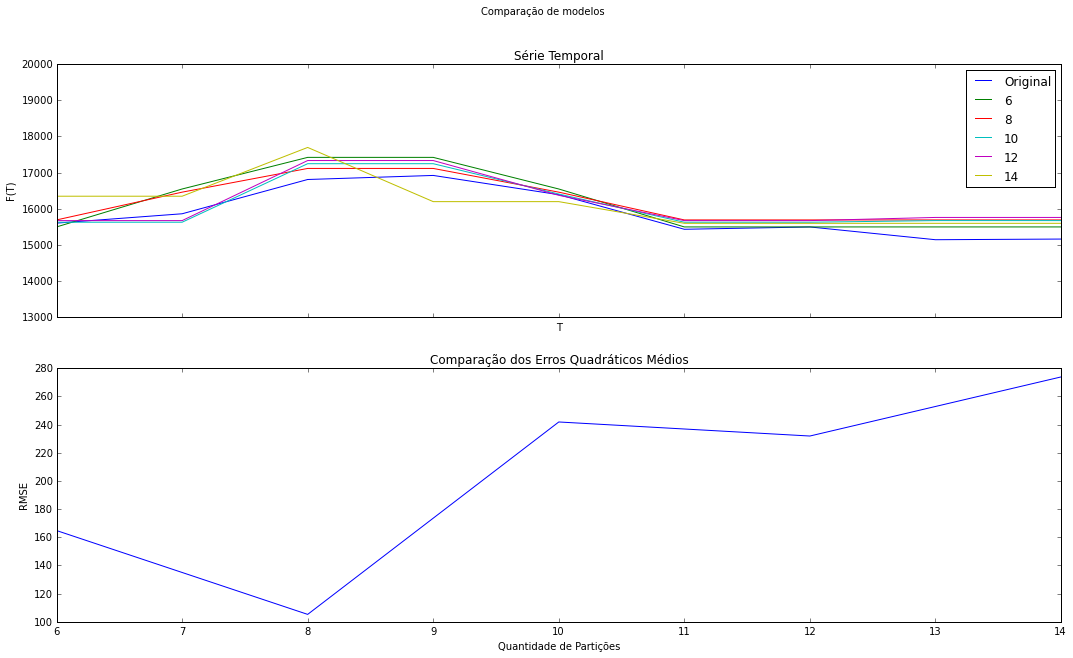

In [172]:
best = SelecaoSimples_MenorRMSE(enrollments["Enrollments"],[6,8,10,12,14], WeightedFTS)

In [173]:
print(best)

A5 -> A5(0.166666666667),A4(0.333333333333),A6(0.5)
A4 -> A5(0.166666666667),A3(0.333333333333),A5(0.5)
A6 -> A7(1.0)
A7 -> A7(0.333333333333),A1(0.666666666667)
A2 -> A3(1.0)
A0 -> A1(1.0)
A3 -> A3(0.0357142857143),A3(0.0714285714286),A4(0.107142857143),A3(0.142857142857),A3(0.178571428571),A3(0.214285714286),A4(0.25)
A1 -> A1(0.166666666667),A2(0.333333333333),A7(0.5)



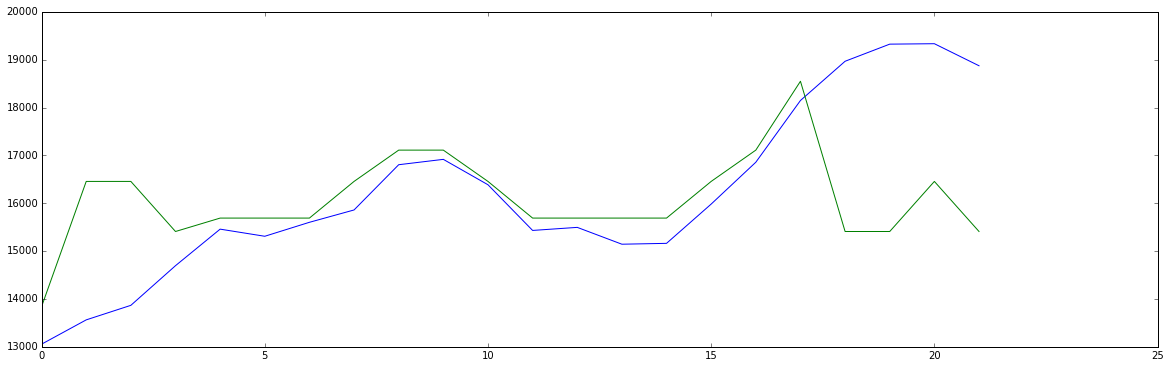

In [174]:
#fts.predict(15000)
pred1 = best.plot(enrollments["Enrollments"])

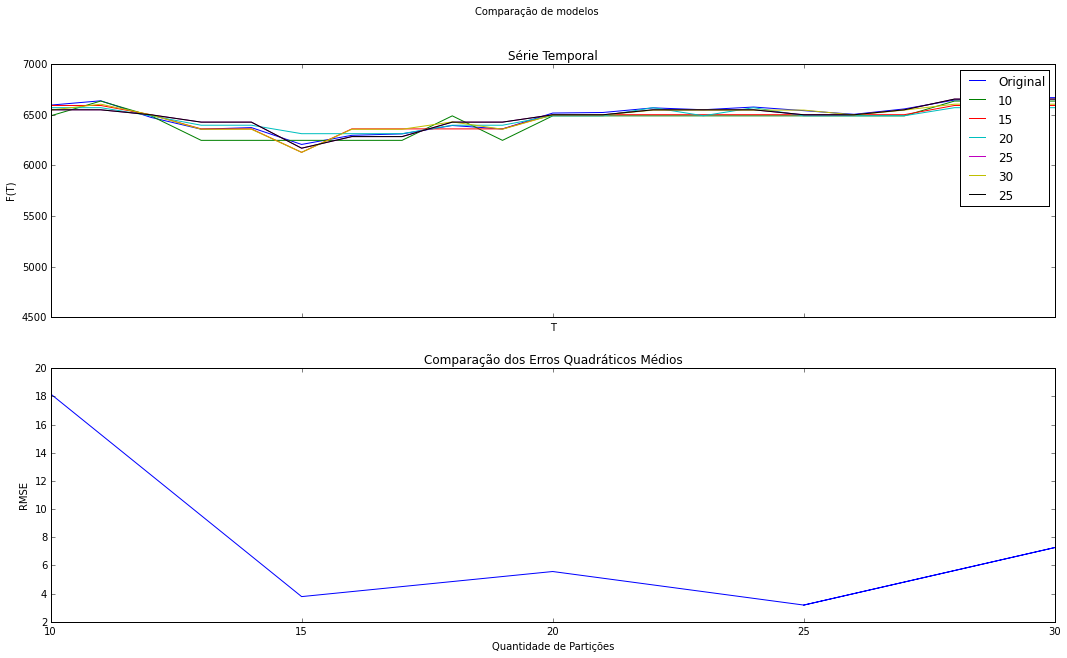

In [175]:
best2 = SelecaoSimples_MenorRMSE(taiexsample,[10,15,20,25,30,25], WeightedFTS)

In [176]:
print(best2)

A12 -> A13(0.010989010989),A11(0.021978021978),A13(0.032967032967),A13(0.043956043956),A13(0.0549450549451),A12(0.0659340659341),A11(0.0769230769231),A12(0.0879120879121),A12(0.0989010989011),A11(0.10989010989),A12(0.120879120879),A11(0.131868131868),A13(0.142857142857)
A11 -> A11(0.0036231884058),A11(0.00724637681159),A12(0.0108695652174),A11(0.0144927536232),A10(0.018115942029),A12(0.0217391304348),A12(0.0253623188406),A11(0.0289855072464),A11(0.0326086956522),A11(0.036231884058),A9(0.0398550724638),A11(0.0434782608696),A11(0.0471014492754),A10(0.0507246376812),A11(0.054347826087),A11(0.0579710144928),A11(0.0615942028986),A11(0.0652173913043),A11(0.0688405797101),A11(0.0724637681159),A10(0.0760869565217),A11(0.0797101449275),A12(0.0833333333333)
A16 -> A16(0.0666666666667),A16(0.133333333333),A15(0.2),A16(0.266666666667),A15(0.333333333333)
A17 -> A18(0.333333333333),A16(0.666666666667)
A2 -> A2(0.00142247510669),A1(0.00284495021337),A0(0.00426742532006),A3(0.00568990042674),A2(0.007

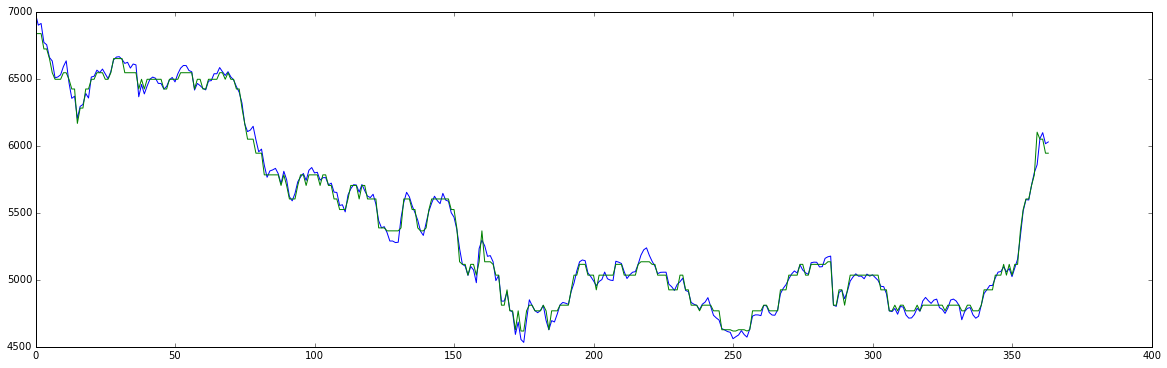

In [177]:
pred2 = best2.plot(taiexsample)

# Improved Weighted Fuzzy Time Series

Os trabalhos de \cite{ismail2011enrollment} e \cite{efendi2013improved} modificam a forma como os pesos são assinalados às regras no modelo de \cite{yu2005weighted}. A diferença mais importante é que a quantidade de recorrências de cada regra é que vai determinar o seu peso, para uma regra $A_i \rightarrow A_j,A_k$, tendo $A_i \rightarrow A_j$ $n_1$ recorrências e $A_i \rightarrow A_k$ $n_2$ recorrências, o valor de cada peso será $w_k = n_k / \sum_{i=1..n} n_i$, sendo $n$ o número de regras.

# Exponentially Weighted Fuzzy Time Series

# High Order Fuzzy Time Series

Essa implementação segue os trabalho de \cite{hwang1998handling} e \cite{chen2014high}



In [ ]:
class HighOrderFTS:
	def __init__(self,order):
		self.sets = {}
		self.order = order

# References

(<a id="cit-song1993fuzzy" href="#call-song1993fuzzy">Song and Chissom, 1993</a>) Song Qiang and Chissom Brad S, ``_Fuzzy time series and its models_'', Fuzzy sets and systems, vol. 54, number 3, pp. 269--277,  1993.

(<a id="cit-chen1996forecasting" href="#call-chen1996forecasting">Chen, 1996</a>) Chen Shyi-Ming, ``_Forecasting enrollments based on fuzzy time series_'', Fuzzy sets and systems, vol. 81, number 3, pp. 311--319,  1996.

(<a id="cit-hwang1998handling" href="#call-hwang1998handling">Hwang, Chen <em>et al.</em>, 1998</a>) Hwang Jeng-Ren, Chen Shyi-Ming and Lee Chia-Hoang, ``_Handling forecasting problems using fuzzy time series_'', Fuzzy sets and systems, vol. 100, number 1, pp. 217--228,  1998.

(<a id="cit-chen2014high" href="#call-chen2014high">Chen, 2014</a>) Chen Mu-Yen, ``_A high-order fuzzy time series forecasting model for internet stock trading_'', Future Generation Computer Systems, vol. 37, number , pp. 461--467,  2014.

